<h1>Predicting ocean proximity in Californian housing dataset using a Neural Network

In this notebook we build multiple models to predict the ocean proximity parameter in a dataset of Californian houses using tensorflow and keras. First we must pre-process the data.

In [1]:
%matplotlib inline 

import numpy as np 
np.random.seed(42)

import matplotlib
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.8.0'

In [4]:
np.random.seed(42)
tf.random.set_seed(42)
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [5]:
import pandas as pd
data = pd.read_csv('housing/housing.csv')
#data = pd.read_csv('/content/gdrive/My Drive/[...]/housing/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Above we can get an overview of the dataset we're working with. Now to extract the test and train data as well as scale it and manipulate it to a suitable shape for our NN.

In [6]:
from sklearn.impute import SimpleImputer 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = data.copy().drop(["ocean_proximity"], axis=1)
Y = data.copy()["ocean_proximity"]
Y = data.copy()["ocean_proximity"].map({"<1H OCEAN":0, "INLAND":1, 
                                        "ISLAND": 2, "NEAR BAY": 3, 
                                        "NEAR OCEAN": 4}).values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    train_size=0.8, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, 
                                                  test_size=0.2, train_size=0.8, 
                                                  random_state=42)


In [7]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)

X_train = imputer.transform(X_train)
X_dev = imputer.transform(X_dev)
X_test = imputer.transform(X_test)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

In [8]:
print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)
print(X_train[:3])

(13209, 9)
(3303, 9)
(4128, 9)
[[-0.69155432  1.10281811 -0.12449485 -0.44361185 -0.60289408 -0.48710064
  -0.64120663  0.44340968 -0.25873131]
 [ 0.8544348  -0.72493883 -1.07770852  1.75575918  1.99734983  1.69902706
   2.04218568  0.00321001 -0.28999612]
 [ 0.86440892 -0.88428174 -0.20392932 -0.15088981 -0.02963101 -0.13535041
  -0.16516379 -0.52181236 -0.01729749]]


To begin with let's try a simple model with 2 layers (including a hidden layer with 10 neurons) using stochastic gradient descent for optimisation. This will act as a baseline measurement for accuracy which we will use to tune our hyperparameters in development.

In [9]:
tf.keras.backend.clear_session

ocean_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(9,), activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

ocean_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])  

Below is a procedure to train and evaluate any model passed to it, this will be useful in testing and development later. Using mini-batching let's run this model for *10 epochs* with *batch_size=10* and investigate its accuracy.

In [10]:
def train_evaluate_model(model, bs=25, eps=25, vb=False):
    model.fit(X_train, y_train, batch_size=bs, epochs=eps, verbose=vb)
    dev_loss, dev_accuracy = model.evaluate(X_dev, y_dev)
    print(f"final loss: {dev_loss} \nfinal accuracy {dev_accuracy}")
    
train_evaluate_model(ocean_model, 10, 10, True)

Epoch 1/10
1321/1321 [==============================] - 2s 963us/step - loss: 0.8219 - accuracy: 0.7147
Epoch 2/10
1321/1321 [==============================] - 1s 847us/step - loss: 0.7621 - accuracy: 0.7302
Epoch 3/10
1321/1321 [==============================] - 1s 1ms/step - loss: 0.8349 - accuracy: 0.7340
Epoch 4/10
1321/1321 [==============================] - 1s 1ms/step - loss: 0.7242 - accuracy: 0.7320
Epoch 5/10
1321/1321 [==============================] - 1s 939us/step - loss: 0.8087 - accuracy: 0.7291
Epoch 6/10
1321/1321 [==============================] - 1s 1ms/step - loss: 0.8118 - accuracy: 0.7287
Epoch 7/10
1321/1321 [==============================] - 1s 953us/step - loss: 0.7645 - accuracy: 0.7295
Epoch 8/10
1321/1321 [==============================] - 1s 843us/step - loss: 0.8290 - accuracy: 0.7287
Epoch 9/10
1321/1321 [==============================] - 1s 929us/step - loss: 0.7844 - accuracy: 0.7170
Epoch 10/10
104/104 [==============================] - 0s 925us/step -

We can see here a relatively okay accuracy of **~0.70** and a rather poor loss of **~0.82** Both of these performance measures can certainly be improved upon with tweaks to the hyperparameters of the model. Firstly let's see what happens when we change *batch_size* and *epochs* both to 25.

In [11]:
train_evaluate_model(ocean_model, 25, 25)

104/104 [==============================] - 0s 836us/step - loss: 0.6204 - accuracy: 0.7802
final loss: 0.62040114402771 
final accuracy 0.7801998257637024


Evidently a significant improvement to loss which is now **~0.62** and a marked increase in accuracy to **~0.78**. Having noted this performance increase due to changing batch and epoch size, let's investigate the effects of changing the number of neurons in the hidden layer from 10 to 20.

In [12]:
tf.keras.backend.clear_session

#20 neurons this time around
ocean_model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=(9,), activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

ocean_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])  

train_evaluate_model(ocean_model)

104/104 [==============================] - 0s 757us/step - loss: 0.4138 - accuracy: 0.8320
final loss: 0.4137909412384033 
final accuracy 0.8319709300994873


Increasing the number of neurons in the hidden layer from 10 to 20 has clearly made a significant difference to both accuracy and loss with strong improvements observed in both (we now see **~0.41** loss and **~0.83** accuracy). Having tuned the number of neurons and the mini-batch parameters for the training of the model, let's change the optimization of the network and see if any improvement is observed. Here we will be using *Adam* optimization with the following hyperparameters:
- $Learning Rate = 0.001$
- $\beta_{1} = 0.9$
- $\beta_{2} = 0.999$
- $\epsilon = 10^{-7}$

In [13]:
tf.keras.backend.clear_session

ocean_model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=(9,), activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

ocean_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])  

train_evaluate_model(ocean_model)

104/104 [==============================] - 0s 736us/step - loss: 0.3023 - accuracy: 0.8738
final loss: 0.3022878170013428 
final accuracy 0.873751163482666


We note here a slight improvement in accuracy (**~0.88**) over the stochastic gradient descent optimizer and a marked improvement in loss (**~0.30**). Let's now try using the RMSprop optimizer to see if we can note any performance increase.

In [14]:
tf.keras.backend.clear_session

ocean_model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=(9,), activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

ocean_model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=['accuracy'])

train_evaluate_model(ocean_model)

104/104 [==============================] - 0s 807us/step - loss: 0.3245 - accuracy: 0.8731
final loss: 0.32454806566238403 
final accuracy 0.8731456398963928


While accuracy and loss are both quite good using RMSprop it is still outperformed by Adam optimization and as such we're going to remain using Adam. Let's try tweaking the *learning_rate* hyperparameter of the Adam optimizer to 0.0015 and see if we observe any performance boosts. 

In [15]:
tf.keras.backend.clear_session

ocean_model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=(9,), activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

ocean_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0015, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])  

train_evaluate_model(ocean_model)

104/104 [==============================] - 0s 761us/step - loss: 0.2767 - accuracy: 0.8871
final loss: 0.2766778767108917 
final accuracy 0.8870723843574524


Here we can see a minimal increase in accuracy (to **~0.89**) and a slight decrease in loss (to **~0.28**). We will thus keep the learning rate at 0.0015 in order to utilise these slight increases in performance. Having tuned and tested a sequantial neural network, let's see how a neural net with a regressive loss function performs on the same task.

In [16]:
reg_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation="relu", input_shape=(9,)),
    tf.keras.layers.Dense(1)
])

reg_model.compile(loss="mean_squared_error", 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3))

reg_model.fit(X_train, y_train, 25, 25, False)
mse = reg_model.evaluate(X_dev, y_dev)
print(f"mean absolute error: {mse}")

104/104 [==============================] - 0s 688us/step - loss: 1.4171
mean absolute error: 1.4171210527420044


The performance of the regression model is not fantastic with an MSE value of **~1.47** meaning there are certainly improvement to be made to the model. We will not tune this further as our other model currently outperfoms the regression model at this point in time. Let's now evaluate our tuned model on the test set and observe the results.

In [17]:
tf.keras.backend.clear_session

ocean_model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=(9,), activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

ocean_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0015, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])  

history = ocean_model.fit(X_train, y_train, batch_size=25, epochs=25,
                    validation_data=(X_test, y_test), verbose=False)

final_loss, final_acc = ocean_model.evaluate(X_test, y_test)
print(f"final loss: {final_loss} \nfinal accuracy {final_acc}")

129/129 [==============================] - 0s 1ms/step - loss: 0.2967 - accuracy: 0.8757
final loss: 0.2966945469379425 
final accuracy 0.8757267594337463


As can be observed above our final tuned model has a high accuracy (**~0.88**) and a low loss (**~0.28**) on the test set using 2 layers and Adam optimization, trained with a mini-batch size of 25 over 25 epochs. Further tuning of hyperparameters will likely lead to a further increase in performance. Let's now graph the results of the evaluation.

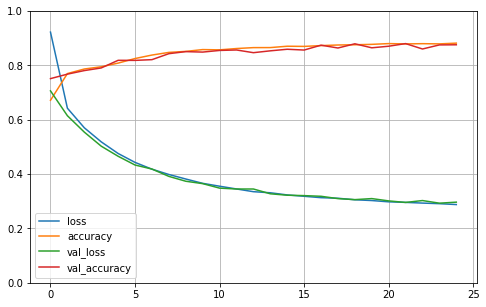

In [18]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

A sharp improvement can be seen in the first 10 epochs which slowly levels out over epochs 10 to 25. This suggests that a higher number of epochs would net negligable performance improvements. The model has now had its hyperparameters tuned. Below is a summary of the final model.

In [19]:
ocean_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                200       
                                                                 
 dense_13 (Dense)            (None, 5)                 105       
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
